In [1]:
import sys
sys.path.append('/home/raghav/sunbather2/src/') #add your path to /sunbather/src/ here

import tools
import RT
import construct_parker as cp

import matplotlib.pyplot as plt
import numpy as np

/home/raghav/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
/home/raghav/.local/lib/python3.10/site-packages/p_winds/tools.py:24: UserWarning: Environment variable PWINDS_REFSPEC_DIR is not set.
  warn("Environment variable PWINDS_REFSPEC_DIR is not set.")


In [2]:
basepath = "/home/raghav/project_sb/sims/"
def atmabundance(filename):
    depths = []
    abund = []
    flag = 0
    with open(basepath+filename) as f:
        for line in f:
            words = line.split()
            if(flag==1 and '#' not in words[0]):
                if('end' in words):
                    break
                depths.append(float(words[0]))
                abund.append(float(words[1]))
            if (words[0] =='#' and 'abundance' in words):
                next(f)
                flag = 1
    depth_array = np.array(depths)
    abund_array = np.array(abund)
    xp = depth_array[1:]
    fp = abund_array[1:]
    x = np.linspace(depth_array[1],depth_array[-1],1000)
    y = np.interp(x,xp,fp)
    #ticks_array = xp
    return x,y,xp,fp


In [3]:
def mu_HHe(Hefrac):
    '''
    This function takes an array of Helium abundances varying with radius and calculates the mean molecular weight. It assumes 0 ionization.
    The input parameter is temporary, it will probably be different after I incorporate crossover mass. The array should be something like [1.0e-10, 1.019e-10, 1.023e-10,......,1,9.8e-02,1.0e-01] 
    but can also be descending order
    '''
    h_fraction = 1-Hefrac
    he_h_fraction = Hefrac / h_fraction
    mean_f_ion = 0.0
    mu_array = (1 + 4*he_h_fraction)/(1 + he_h_fraction + mean_f_ion)

    mu_0 = np.mean(mu_array)
    return mu_0

In [4]:
def muarray_HHe(Hefrac,f_r=0.0):
    '''
    This function takes an array of Helium abundances varying with altitude and the fraction of ionized hydrogen with planetary radius, and returns array of mean molecular weights with altitude.
    It assumes no Helium ionization. The input parameter Hefrac is temporary, it will probably be different after I incorporate crossover mass. The array should be something like [1.0e-10, 1.019e-10, 1.023e-10,......,1,9.8e-02,1.0e-01] 
    but can also be descending order
    '''
    h_fraction = 1-Hefrac
    mu_array = ((1-h_fraction)*4.0 + h_fraction)/(h_fraction*(1+f_r)+(1-h_fraction))
    return mu_array

In [5]:
# def create_profile(ele,altarray):
#     '''
#     Temporary method to create abundance profile for fractionated elements. I am arbitrarily assuming that the abundance drops by 3 orders of magnitude over 1 Rp, 
#     then drops to 1e-15 by 8Rp.
#     '''
#     zdict = tools.get_abundances()
#     totalele = len(altarray)
#     ini_abundance = np.log10(zdict[ele])
#     inter_abundance = ini_abundance-3 #abundance assumed to go down by 3 orders of magnitude over 1 Rp
#     rp2 = altarray[0]*2
#     elenum = np.argwhere(altarray>rp2)[0]
#     abunarray1 = np.logspace(ini_abundance,inter_abundance,elenum.item())
#     rem_elenum = totalele - elenum.item()
#     abunarray2 = np.logspace(inter_abundance,-15,rem_elenum+1)
#     abundance_array = np.concatenate((abunarray1,abunarray2[1:]))
#     return abundance_array

In [6]:
def abunprofile(ele,altarray,plawindex=-2):
    zdict = tools.get_abundances()
    ini_abundance = zdict[ele]
    radarray = altarray/altarray[0]
    abunarray = ini_abundance*(radarray**plawindex)
    Clabunarray = tools.alt_array_to_Cloudy(altarray,abunarray,8,altarray[0],1000,log=True)
    return Clabunarray

In [7]:
def find_fracelements(cmass):
    mass_dict = {'H':1.6735575e-24, 'He':6.646477e-24, 'Li':1.15e-23, 'Be':1.4965082e-23,
            'B':1.795e-23, 'C':1.9945e-23, 'N':2.3259e-23, 'O':2.6567e-23,
            'F':3.1547e-23, 'Ne':3.35092e-23, 'Na':3.817541e-23, 'Mg':4.0359e-23,
            'Al':4.48038988e-23, 'Si':4.6636e-23, 'P':5.14331418e-23, 'S':5.324e-23,
            'Cl':5.887e-23, 'Ar':6.6335e-23, 'K':6.49243e-23, 'Ca':6.6551e-23,
            'Sc':7.4651042e-23, 'Ti':7.9485e-23, 'V':8.45904e-23, 'Cr':8.63416e-23,
            'Mn':9.1226768e-23, 'Fe':9.2733e-23, 'Co':9.786087e-23, 'Ni':9.74627e-23,
            'Cu':1.0552e-22, 'Zn':1.086e-22}
    #https://stackoverflow.com/questions/18807079/selecting-elements-of-a-python-dictionary-greater-than-a-certain-value
    #This gets all the elements that are heavier than the crossover mass, i.e. elements that would not be lifted into upper atm
    frac_list = list(k for k, v in mass_dict.items() if v > cmass)     
    return frac_list

In [8]:
def create_zdicts(fraclist,altarray,plawindex=-2):
    '''
    This function takes the elements that are fractionated and creates a list of dictionaries corresponding to abundances at different altitudes.
    altarray is currently taken from a parker profile i.e. construct_parker run, and may need to be defined alternatively.
    '''
    frac_abundances = []
    #This loop gets the absolute (not relative to hydrogen) number (not mass) abundance profile for each fractionated element
    for ele in fraclist:
        #frac_abundances.append(create_profile(ele,altarray))
        abundance_profile = abunprofile(ele,altarray,plawindex)
        frac_abundances.append(10**abundance_profile[:,1])
    zdictlist = []
    for i in range(len(abundance_profile[:,0])):
        zelemdict = dict((ele,abun[i]) for (ele,abun) in zip(fraclist,frac_abundances)) 
        #This gets abundance of each fractionated element relative to solar at a particular altitude and stores in a dictionary
        #This dictionary serves as the zelem argument for get_zdict
        zdictlist.append(tools.get_zdict(zelem=zelemdict)) #This now has an abundance dictionary at each altitude
    return zdictlist

In [9]:
def calc_fracmubar(zdictlist):
    '''
    This function gets the initial neutral average mean molecular weight for a fractionated atmosphere.
    It returns both the mean molecular weight across the entire atmosphere, as well as the mean molecular weight varying with
    altitude.
    '''
    mulist = []
    for zdict in zdictlist:
        mulist.append(cp.calc_neutral_mu(zdict))
    frac_mubar = np.mean(mulist)
    return frac_mubar, mulist

In [10]:
def create_zarraydict(fraclist,abunproflist):
    '''
    Creates a single dictionary with the abundance profile arrays for fractionated elements as keys, instead of a list of dictionaries like create_zdicts
    fraclist- list of elements being fractionated
    abunproflist - corresponding abundance profiles, created using abunprofile
    '''
    zelemdict = dict((fraclist[i],abunproflist[i]) for i in range(len(fraclist)))
    zarraydict = tools.get_zdict(zelem = zelemdict)
    return zarraydict

In [11]:
def write_abundancelaws(simname,zdict=None,alaw=None): 
    with open(simname+".in","w") as f:
        f.write("# ======== Abundance laws ==========")
        for ele,prof in zdict.items():
            if type(prof) is np.ndarray:
                elename = tools.element_names[ele]
                alaw = tools.remove_duplicates(prof,"1.7f")
                f.write("\n# ======= " + elename + " abundance law ======") 
                f.write("\nelement " + elename + " table depth\n")
                np.savetxt(f, alaw, fmt='%1.7f')
                f.write('{:.7f}'.format(alaw[-1,0]+0.1)+
                        ' '+'{:.7f}'.format(alaw[-1,1]))             
                f.write("\nend of table")

**Fractionation in Hydrogen/Helium Atmosphere of generic hot Neptune**

In [12]:
hotNep = tools.Planet('hotNeptune')
spec = cp.cloudy_spec_to_pwinds(tools.cloudypath+'data/SED/'+hotNep.SEDname, 1., (hotNep.a - 20*hotNep.R)/tools.AU)
cp.save_plain_parker_profile(hotNep,10.9,5100,spec,h_fraction=0.9,pdir='test1',overwrite=True)

Parker wind profile done: /home/raghav/project_sb/parker_profiles/hotNeptune/test1/pprof_hotNeptune_T=5100_M=10.900.txt


In [13]:
pprof_hotNep = tools.read_parker('hotNeptune',5100,10.900,'test1')
original_muarray = pprof_hotNep.mu.values
hotNep_altarray = pprof_hotNep.alt.values

**Fractionation in atmosphere with metals (WASP52b)**

In [14]:
WASPplanet = tools.Planet('WASP52b')
pprof_WASP52 = tools.read_parker('WASP52b',9200,11.300,'z_1')
WASP52_altarray = pprof_WASP52.alt.values

In [15]:
altitudearray = WASPplanet.R * np.logspace(0,np.log10(20),1000)
mgprof = abunprofile('Mg',altitudearray,-5)

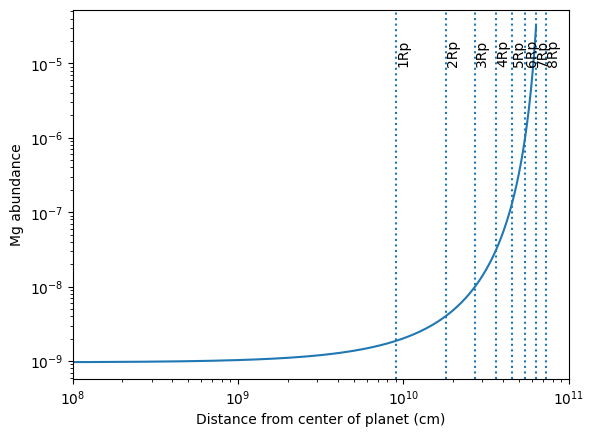

In [16]:
mgproffig = plt.figure()
#plt.plot(altitudearray,mgprof)
plt.plot(10**mgprof[:,0],10**mgprof[:,1])
plt.xlim(1e8,1e11)
for i in range(1,9):
    plt.axvline(i*WASPplanet.R,linestyle='dotted')
    plt.text(i*WASPplanet.R,1e-5,f"{i}Rp",rotation=90)
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Mg abundance')
plt.xlabel('Distance from center of planet (cm)')
plt.show()

In [17]:
Mgfracdictlists = create_zdicts(['Mg'],altitudearray)
mgfrac_mubar,mgfrac_muvar = calc_fracmubar(Mgfracdictlists)
print(mgfrac_mubar)

1.2845141962603062


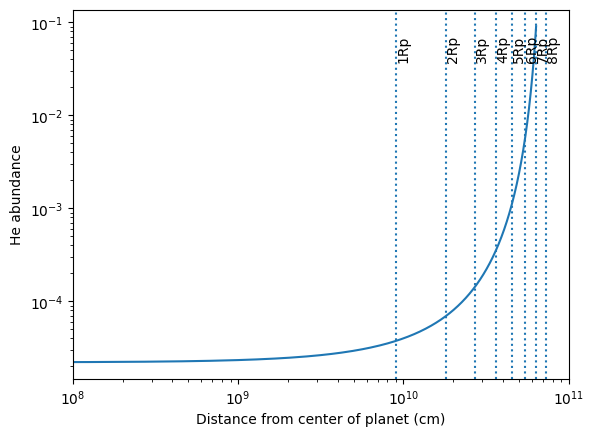

In [18]:
heprof = abunprofile('He',altitudearray,-4)
heproffig = plt.figure()
#plt.plot(altitudearray,heprof)
plt.plot(10**heprof[:,0],10**heprof[:,1])
plt.xlim(1e8,1e11)
for i in range(1,9):
    plt.axvline(i*WASPplanet.R,linestyle='dotted')
    plt.text(i*WASPplanet.R,4e-2,f"{i}Rp",rotation=90)
plt.xscale('log')
plt.yscale('log')
plt.ylabel('He abundance')
plt.xlabel('Distance from center of planet (cm)')
plt.show()

In [19]:
hefracdictlists = create_zdicts(['He'],altitudearray,-4)
hefrac_mubar,hefrac_muvar = calc_fracmubar(hefracdictlists)
print(hefrac_mubar)

1.0195990848162253


In [20]:
multifracdictlists = create_zdicts(['He','Li','F'],altitudearray)
mfrac_mubar,mfrac_muvar = calc_fracmubar(multifracdictlists)
print(mfrac_mubar)

1.0221854983720762


In [21]:
mgheprofdict = create_zarraydict(['He','Mg'],[heprof,mgprof])

In [22]:
for ele,prof in mgheprofdict.items():
    if(type(prof) is np.ndarray):
        print(ele)
        

He
Mg


In [23]:
write_abundancelaws("/home/raghav/project_sb/sims/HeFrac/testw",mgheprofdict)

In [28]:
alphaelementlist = ['He','Li','F','Mg']
alphadictlists = create_zdicts(alphaelementlist,altitudearray,plawindex=-4)
profiles = []
for ele in alphaelementlist:
    profiles.append(abunprofile(ele,altitudearray,-4))
alphaprofdict = create_zarraydict(alphaelementlist,profiles)

In [29]:
write_abundancelaws("/home/raghav/project_sb/sims/HeFrac/alpha",alphaprofdict)